✅ 原始数据维度 / Raw data shape: (45211, 19)
列名预览 / Columns preview: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'rf_prob_yes', 'rf_predicted_class']

✅ 未订阅客户数 / Non-subscribers count: 39922

📊 未订阅客户的概率分布 / Predicted prob summary (y = 'no'):
count    39922.000000
mean         0.036260
std          0.082125
min          0.000000
25%          0.000000
50%          0.004000
75%          0.028000
max          0.932000
Name: pred_prob, dtype: float64

⚙️ 模型假设 / Assumptions:
  - call_cost (per call) = €5
  - profit_per_sub (per new subscriber) = €50

📊 ROI 结果前几行 / ROI table preview:


,threshold,n_targeted,expected_subs,total_cost,expected_revenue,expected_profit
0,0.00,39922,1447.574,199610,72378.7,-127231.3
1,0.01,15131,1410.406,75655,70520.3,-5134.7
2,0.02,11710,1364.502,58550,68225.1,9675.1
3,0.03,9929,1322.302,49645,66115.1,16470.1
4,0.04,8662,1279.630,43310,63981.5,20671.5



=== 关键结论 / Key thresholds (for ONE extra call to y = 'no') ===
✅ Break-even threshold (不亏本最低概率阈值): 0.02
✅ Profit-maximizing threshold (利润最大阈值): 0.10
   → Expected profit ≈ €27,649, n_targeted = 4745 customers


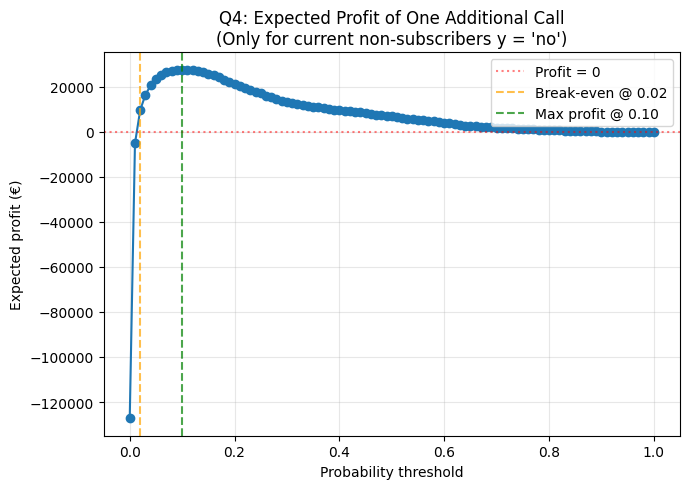

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# 1. 读取数据 / Load data
# ================================
file_path = r"D:\Icey\tcd\notebooks\foundation of BA\group assignment\bank+marketing\bank\df_with_predictions.csv"
df = pd.read_csv(file_path)

print("✅ 原始数据维度 / Raw data shape:", df.shape)
print("列名预览 / Columns preview:", df.columns.tolist()[:20])

# ================================
# 2. 只保留当前尚未订阅的客户（y = 'no'）
#    Focus on customers who have NOT subscribed yet
# ================================
if "y" not in df.columns:
    raise ValueError("⚠️ 数据中找不到列 'y'，请确认是否包含订阅结果变量。")

df_q4 = df[df["y"] == "no"].copy()
print("\n✅ 未订阅客户数 / Non-subscribers count:", df_q4.shape[0])

# 使用 Q3 随机森林预测的订阅概率 rf_prob_yes
# Use rf_prob_yes (Q3 RF prediction) as predicted subscription probability
if "rf_prob_yes" not in df_q4.columns:
    raise ValueError("⚠️ 数据中找不到列 'rf_prob_yes'，请确认 Q3 是否已输出此列。")

df_q4["pred_prob"] = df_q4["rf_prob_yes"]

print("\n📊 未订阅客户的概率分布 / Predicted prob summary (y = 'no'):")
print(df_q4["pred_prob"].describe())

# ================================
# 3. 业务假设参数 / Business assumptions
#    优化的是“是否新增这一通电话”的决策
# ================================
call_cost = 5          # 每打一通电话的成本 (€) / cost per additional call
profit_per_sub = 50    # 每个新增成功订阅的净利润 (€) / net profit per new subscription

print(f"\n⚙️ 模型假设 / Assumptions:")
print(f"  - call_cost (per call) = €{call_cost}")
print(f"  - profit_per_sub (per new subscriber) = €{profit_per_sub}")

# ================================
# 4. 遍历不同概率阈值，计算“新增一通外呼”的预期利润
#    Sweep thresholds and compute expected profit for one extra call
# ================================
thresholds = np.arange(0.0, 1.01, 0.01)
rows = []

for t in thresholds:
    # 规则：只给预测概率 >= t 的客户打这一通新增电话
    # Rule: call only customers with pred_prob >= t
    df_q4["targeted"] = (df_q4["pred_prob"] >= t).astype(int)

    # 需要新增拨打的客户数量 / number of customers to be called
    n_targeted = df_q4["targeted"].sum()

    # 期望新增成功订阅人数（用概率作为期望值加总）
    # Expected number of new subscriptions, using probabilities as expectations
    expected_subs = (df_q4["pred_prob"] * df_q4["targeted"]).sum()

    # 总成本：每个被选中的客户，新增打一通，成本为 call_cost
    # Total cost: each targeted customer gets ONE extra call
    total_cost = n_targeted * call_cost

    # 期望总收益：新增订阅人数 × 每个订阅的净利润
    # Expected total revenue: expected_subs × profit_per_sub
    expected_revenue = expected_subs * profit_per_sub

    # 预期利润：收益 - 成本
    # Expected profit: revenue - cost
    expected_profit = expected_revenue - total_cost

    rows.append([
        t,
        n_targeted,
        expected_subs,
        total_cost,
        expected_revenue,
        expected_profit
    ])

roi_df = pd.DataFrame(rows, columns=[
    "threshold",
    "n_targeted",
    "expected_subs",
    "total_cost",
    "expected_revenue",
    "expected_profit"
])

print("\n📊 ROI 结果前几行 / ROI table preview:")
display(roi_df.head())

# ================================
# 5. 找出“不亏本阈值”和“利润最大阈值”
#    Find break-even threshold and profit-maximizing threshold
# ================================
be_row = roi_df[roi_df["expected_profit"] >= 0]

if not be_row.empty:
    break_even_t = be_row["threshold"].min()
else:
    break_even_t = None

best_idx = roi_df["expected_profit"].idxmax()
best_t = roi_df.loc[best_idx, "threshold"]
best_profit = roi_df.loc[best_idx, "expected_profit"]
best_n = roi_df.loc[best_idx, "n_targeted"]

print("\n=== 关键结论 / Key thresholds (for ONE extra call to y = 'no') ===")
if break_even_t is not None:
    print(f"✅ Break-even threshold (不亏本最低概率阈值): {break_even_t:.2f}")
else:
    print("⚠️ 在 0–1 范围内，没有阈值可以做到新增一通也不亏本。")

print(f"✅ Profit-maximizing threshold (利润最大阈值): {best_t:.2f}")
print(f"   → Expected profit ≈ €{best_profit:,.0f}, "
      f"n_targeted = {best_n} customers")

# ================================
# 6. 可视化：不同阈值下的预期利润曲线
#    Visualise expected profit vs threshold
# ================================
plt.figure(figsize=(7, 5))
plt.plot(roi_df["threshold"], roi_df["expected_profit"], marker="o")

plt.axhline(0, linestyle=":", color="red", alpha=0.5, label="Profit = 0")

if break_even_t is not None:
    plt.axvline(break_even_t, linestyle="--", color="orange", alpha=0.7,
                label=f"Break-even @ {break_even_t:.2f}")
plt.axvline(best_t, linestyle="--", color="green", alpha=0.7,
            label=f"Max profit @ {best_t:.2f}")

plt.xlabel("Probability threshold")
plt.ylabel("Expected profit (€)")
plt.title("Q4: Expected Profit of One Additional Call\n(Only for current non-subscribers y = 'no')")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


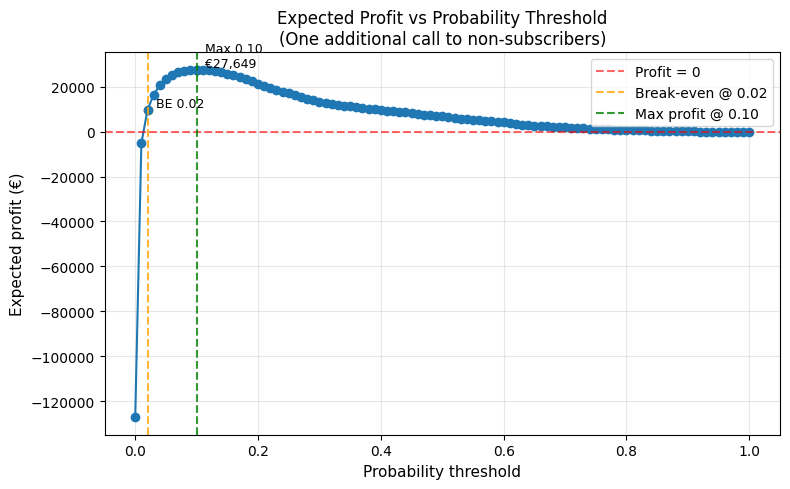

In [12]:
import matplotlib.pyplot as plt

# 确认 roi_df 中包含需要的列
required_cols = {"threshold", "expected_profit"}
missing = required_cols - set(roi_df.columns)
if missing:
    raise ValueError(f"roi_df 缺少列: {missing}")

# 重新计算关键点（以防你中间有修改）
be_row = roi_df[roi_df["expected_profit"] >= 0]
break_even_t = be_row["threshold"].min() if not be_row.empty else None

best_idx = roi_df["expected_profit"].idxmax()
best_t = roi_df.loc[best_idx, "threshold"]
best_profit = roi_df.loc[best_idx, "expected_profit"]

# ==== 绘图 / Plot ====
plt.figure(figsize=(8, 5))

# 主曲线 / main profit curve
plt.plot(
    roi_df["threshold"],
    roi_df["expected_profit"],
    marker="o",
    linewidth=1.5
)

# 零利润基准线 / zero-profit line
plt.axhline(0, linestyle="--", color="red", alpha=0.6, label="Profit = 0")

# 不亏本阈值 / break-even threshold
if break_even_t is not None:
    be_profit = roi_df.loc[roi_df["threshold"] == break_even_t, "expected_profit"].values[0]
    plt.axvline(break_even_t, linestyle="--", color="orange", alpha=0.8,
                label=f"Break-even @ {break_even_t:.2f}")
    plt.scatter(break_even_t, be_profit, color="orange")
    plt.text(break_even_t, be_profit,
             f"  BE {break_even_t:.2f}",
             va="bottom", ha="left", fontsize=9)

# 利润最大阈值 / profit-maximising threshold
plt.axvline(best_t, linestyle="--", color="green", alpha=0.8,
            label=f"Max profit @ {best_t:.2f}")
plt.scatter(best_t, best_profit, color="green")
plt.text(best_t, best_profit,
         f"  Max {best_t:.2f}\n  €{best_profit:,.0f}",
         va="bottom", ha="left", fontsize=9)

plt.xlabel("Probability threshold", fontsize=11)
plt.ylabel("Expected profit (€)", fontsize=11)
plt.title("Expected Profit vs Probability Threshold\n(One additional call to non-subscribers)", fontsize=12)

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# 选出 break-even 和 profit-max 两个点 / select the two key thresholds
key_t_values = []

if break_even_t is not None:
    key_t_values.append(("Break-even", break_even_t))

key_t_values.append(("Profit-maximising", best_t))

rows = []
for label, t in key_t_values:
    row = roi_df.loc[roi_df["threshold"] == t].iloc[0]
    rows.append({
        "Threshold type": label,
        "Probability": t,
        "Targeted customers": int(row["n_targeted"]),
        "Expected revenue (€)": round(row["expected_revenue"], 1),
        "Cost (€)": round(row["total_cost"], 1),
        "Expected profit (€)": round(row["expected_profit"], 1),
    })

summary_df = pd.DataFrame(rows)
print("Key thresholds summary:")
display(summary_df)


Key thresholds summary:


,Threshold type,Probability,Targeted customers,Expected revenue (€),Cost (€),Expected profit (€)
0,Break-even,0.02,11710,68225.1,58550.0,9675.1
1,Profit-maximising,0.10,4745,51373.6,23725.0,27648.6
